# Torch Adam - Constrained Optimization

In [1]:
import optiland.backend as be
from optiland import optic, optimization

be.set_backend("torch")  # Set the backend to PyTorch
be.grad_mode.enable()  # Enable gradient tracking

Define a starting lens:

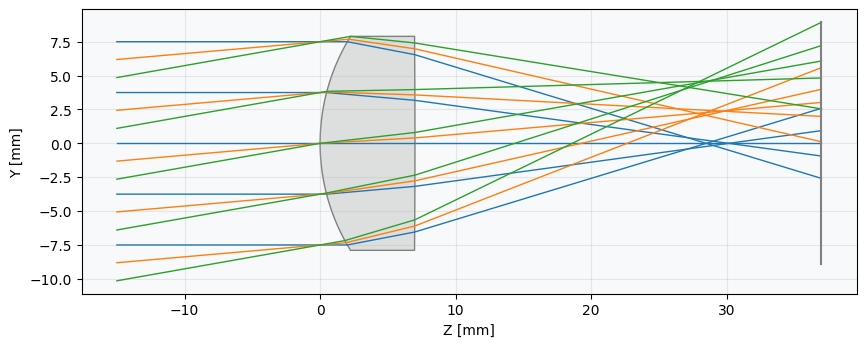

In [2]:
lens = optic.Optic()

# add surfaces
lens.add_surface(index=0, thickness=be.inf)
lens.add_surface(index=1, thickness=7, radius=15, material="N-BK7", is_stop=True)
lens.add_surface(index=2, thickness=30, radius=-1000)
lens.add_surface(index=3)

# set aperture
lens.set_aperture(aperture_type="EPD", value=15)

# add field
lens.set_field_type(field_type="angle")
lens.add_field(y=0)
lens.add_field(y=5)
lens.add_field(y=10)

# add wavelength
lens.add_wavelength(value=0.45, is_primary=True)

# draw lens
_ = lens.draw(num_rays=5)

Define optimization problem:

In [3]:
problem = optimization.OptimizationProblem()

Add operands (targets for optimization):

In [4]:
# 1. add focal length operand
input_data = {"optic": lens}
problem.add_operand(operand_type="f2", target=50, weight=1, input_data=input_data)

# 2. add RMS spot size operand
input_data = {
    "optic": lens,
    "surface_number": -1,
    "Hx": 0,
    "Hy": 0,
    "num_rays": 5,
    "wavelength": 0.55,
    "distribution": "hexapolar",
}

problem.add_operand(
    operand_type="rms_spot_size",
    target=0,
    weight=1,
    input_data=input_data,
)

Define variables - constrain radius 1.

In [5]:
problem.add_variable(lens, "radius", surface_number=1, min_val=10, max_val=30)

Let thickness to image plane vary.

In [6]:
problem.add_variable(lens, "thickness", surface_number=2)

Check initial merit function value and system properties:

In [7]:
problem.info()

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │                478.315 │                 0 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤════════════════╤══════════╤══════════════╤══════════════╤══════════╤═════════╤═════════╤════════════════╕
│    │ Operand Type   │   Target │ Min. Bound   │ Max. Bound   │   Weight │   Value │   Delta │   Contrib. [%] │
╞════╪════════════════╪══════════╪══════════════╪══════════════╪══════════╪═════════╪═════════╪════════════════╡
│  0 │ f2             │       50 │              │              │        1 │  28.199 │ -21.801 │          99.37 │
│  1 │ rms spot size  │        0 │              │              │        1 │   1.742 │   1.742 │           0.63 │
╘════╧════════════════╧══════════╧══════════════╧══════════════╧══════════╧═════════╧═════════╧════════════════╛
╒════╤═════════════════╤═══════════╤═════════╤══════════════╤═

Define optimizer:

In [8]:
optimizer = optimization.TorchAdamOptimizer(problem)

Run optimization:

In [9]:
res = optimizer.optimize(n_steps=100, lr=1e-2, gamma=0.99, disp=True)

  Step 0001/100, Loss: 478.315308
  Step 0011/100, Loss: 124.923775
  Step 0021/100, Loss: 185.888733
  Step 0031/100, Loss: 257.354340
  Step 0041/100, Loss: 209.178726
  Step 0051/100, Loss: 205.711151
  Step 0061/100, Loss: 223.519455
  Step 0071/100, Loss: 217.703644
  Step 0081/100, Loss: 213.703568
  Step 0091/100, Loss: 216.955887
  Step 0100/100, Loss: 217.338837


Print merit function value and system properties after optimization:

In [10]:
problem.info()

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │                217.209 │                 0 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤════════════════╤══════════╤══════════════╤══════════════╤══════════╤═════════╤═════════╤════════════════╕
│    │ Operand Type   │   Target │ Min. Bound   │ Max. Bound   │   Weight │   Value │   Delta │   Contrib. [%] │
╞════╪════════════════╪══════════╪══════════════╪══════════════╪══════════╪═════════╪═════════╪════════════════╡
│  0 │ f2             │       50 │              │              │        1 │  35.262 │ -14.738 │            100 │
│  1 │ rms spot size  │        0 │              │              │        1 │   0.078 │   0.078 │              0 │
╘════╧════════════════╧══════════╧══════════════╧══════════════╧══════════╧═════════╧═════════╧════════════════╛
╒════╤═════════════════╤═══════════╤═════════╤══════════════╤═

Draw final lens:

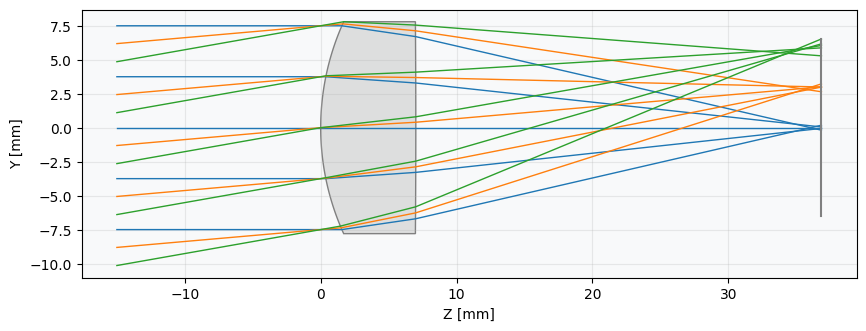

In [11]:
_ = lens.draw(num_rays=5)